## PEtab and AMICI

In this notebook I simulate the model with AMICI based on the recently created PEtab files.

In [1]:
from amici.petab_import import import_petab_problem
from amici.petab_objective import simulate_petab

import amici
import petab

import numpy as np 
import amici.plotting

import os
import pandas as pandas
from IPython.display import HTML, display

import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize

### Import model to AMICI

We import a model to PEtab from a provided yaml file and then import it to AMICI. 

In [2]:
model_name= "Spoegler_conversionReaction"
param_scale="lin"
yaml_file= "/home/vinc777/python_projects/moses/spoegler_model_reduction/petab/"+param_scale+"/"+model_name+".yaml"

petab_problem = petab.Problem.from_yaml(yaml_file)

amici_model = import_petab_problem(petab_problem)

### Simulation
Next we simulate again with AMCICI.

Model name: Sp_gler_ConversionReaction
Model parameters: ('k1', 'k2', 'k3', 'noiseParameter1_observed_B')
Model outputs:    ('observed_B',)
Model states:     ('A', 'B')


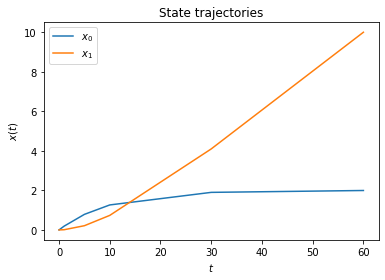

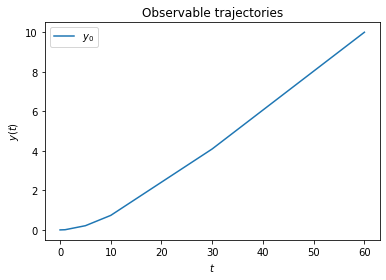

In [3]:
print("Model name:", amici_model.getName())
print("Model parameters:", amici_model.getParameterIds())
print("Model outputs:   ", amici_model.getObservableIds())
print("Model states:    ", amici_model.getStateIds())

solver = amici_model.getSolver()
amici_model.setTimepoints([0,1,5,10,30,60])

amici_model.setParameterByName("k1", 0.2)
amici_model.setParameterByName("k2", 0.1)
amici_model.setParameterByName("k3", 0)

# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(amici_model, solver)
edata = amici.ExpData(rdata, 0.15, 0.0)
# get simulated data
simulations = rdata.x

# plot simulated trajectories
amici.plotting.plotStateTrajectories(rdata)
amici.plotting.plotObservableTrajectories(rdata)

As we can see, we get the same trajectories as in the case, where we used amici based on the sbml file.

In [20]:
# enable sensitivities 
solver.setSensitivityOrder(amici.SensitivityOrder_first)
solver.setSensitivityMethod(amici.SensitivityMethod_forward)
amici_model.requireSensitivitiesForAllParameters()

# create objective function from amici model
objective = pypesto.AmiciObjective(amici_model, solver, [edata])


In [ ]:

# create optimizer object which contains all information for doing the optimization
optimizer = optimize.ScipyOptimizer(method="L-BFGS-B")

# create problem object containing all information on the problem to be solved
problem = pypesto.Problem(objective=objective, lb=[1e-5, 1e-5, 1e-5, 1e-5], ub=[1e3, 1e3, 1e3, 1e3])

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=1000, filename=None
)

best parameter:  [3.68898880e-01 4.41857741e-02 1.88679486e-03 1.86718463e+02]
best likelihood value:  -4.503543093554096


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

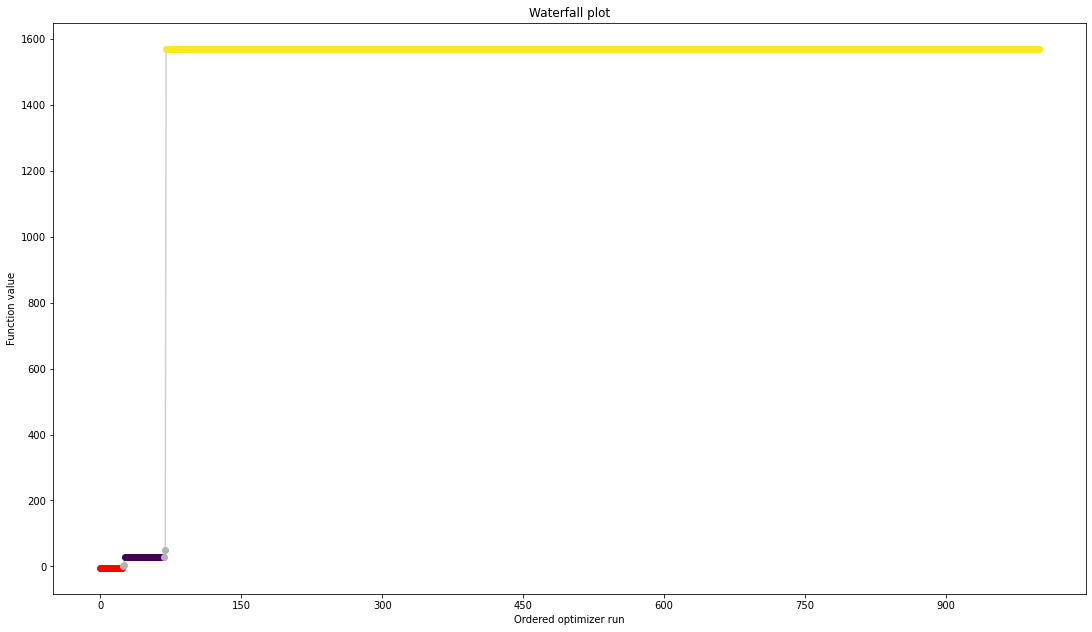

In [9]:
# print results
best_result = result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', objective(best_result))


# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
visualize.waterfall_lowlevel(fvals, scale_y='lin')

In [14]:
# converged means close to the best result up to a threshold

threshold = 1e-2
n_compares = len(result.optimize_result.as_list("x"))
n_converged = 0
for i in range(0, n_compares):
    compare_result = result.optimize_result.as_list("x")[i]["x"]
    converged = (np.abs((compare_result - best_result)) < (threshold * len(compare_result))).all()
    if converged:
        n_converged += 1

print("Number of converged runs: ", n_converged)

Number of converged runs:  1


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

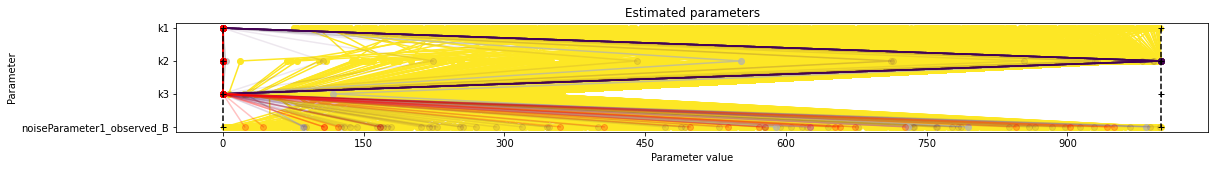

In [21]:
visualize.parameters(result)

In [ ]:
startpoints = result.optimize_result.get_for_key('x0')
sigma_starts = []
length = len(startpoints)
for i in range(0, length):
    new = startpoints[i][3]
    sigma_starts.append(new)
print(sigma_starts)

In [18]:
print(edata)

<amici.amici.ExpData; proxy of <Swig Object of type 'std::vector< amici::ExpData * >::value_type' at 0x7f7fbf031fc0> >
